In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
# mpl setup
mpl.rcParams['image.cmap'] = 'ocean'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2(np.linspace(0, 1, 8)))
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color = [(225/255,102/255,102/255), (82/255,158/255,205/255),  (194/255,226/255,170/255), (225/255,178/255,102/255), (178/255,102/255,225/255),(225/255,225/255,102/255),(102/255,102/255,225/255)])
mpl.rcParams['font.family'] = 'Helvetica Neue'
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['figure.dpi'] = 200
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Formalia

Please read the [assignment overview page](https://laura.alessandretti.com/comsocsci2024/assignments.html) carefully before proceeding. The page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

__If you fail to follow these simple instructions, it will negatively impact your grade!__

**Due date and time**: The assignment is due on April 2nd at 23:59. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Assignment 2)_. 

Remember to include in the first cell of your notebook:
* the link to your group's Git repository 
* group members' contributions


## Part 1: Properties of the real-world network of Computational Social Scientists

These exercises are taken from Week 5.
> __Exercise: Analyzing Networks through a Random Model__ 
>
>
>
> 1. _Random Network_: Let's start by building a Random Network, acting as a baseline (or ["null model"](https://en.wikipedia.org/wiki/Null_model)) to understand the Computational Social Scientists Network better.  
> * First, calculate the probability (_p_) that makes the expected number of edges in our random network match the actual edge count in the Computational Social Scientists network. Refer to equation 3.2 in your Network Science textbook for guidance. After finding _p_, figure out the average degree (using the given formula). 


In [4]:
import csv
import ast
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

authors_csv_path = 'final_authors.csv'
papers_csv_path  = 'final_papers.csv'

def read_authors(author_csv_path):
    authors = []
    author_index = {}
    with open(author_csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for idx, row in enumerate(reader):
            a_id = row['id'].strip()
            author_index[a_id] = idx
            authors.append(a_id)
    return authors, author_index

def build_coauthor_graph(paper_csv_path, author_index):
    G = nx.Graph()
    G.add_nodes_from(author_index.values())
    
    with open(paper_csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            authors_of_paper = ast.literal_eval(row['author_ids'])
            for i in range(len(authors_of_paper)):
                for j in range(i+1, len(authors_of_paper)):
                    a_i = author_index.get(authors_of_paper[i])
                    a_j = author_index.get(authors_of_paper[j])
                    if a_i is not None and a_j is not None:
                        G.add_edge(a_i, a_j)
    return G

authors, a_index = read_authors(authors_csv_path)
N = len(a_index)
G_css = build_coauthor_graph(papers_csv_path, a_index)
L = G_css.number_of_edges()
print(f"CSS network has {N} nodes, {L} edges.")


if N > 1:
    p = (2.0 * L) / (N*(N-1))
else:
    p = 0.0
print(f"Probability p = {p:.6f}")


G_rand = nx.erdos_renyi_graph(N, p)
print(f"Random G(N,p) has {G_rand.number_of_edges()} edges (one realization).")

FileNotFoundError: [Errno 2] No such file or directory: 'final_authors.csv'

> * Now, write a function to generate a Random Network that mirrors the Computational Social Scientists network in terms of node count, using your calculated _p_. Generate a random network by linking nodes in every possible pair with probability _p_. **Hint**: you can use the function [``np.random.uniform``](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to draw samples from a uniform probability distribution.   


> * Visualize the network as you did for the Computational Social Scientists network in the exercise above (my version is below). 
>
> * Answer the following questions __(max 200 words in total)__: 
>    - What regime does your random network fall into? Is it above or below the critical threshold?  
>    - According to the textbook, what does the network's structure resemble in this regime?  
>    - Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations.
>
>   
> 2. _Degree Distribution_: This section focuses on analyzing the degree distribution of both the actual Computational Social Scientists network and its random counterpart.
> * Compute the distribution of degree for the random network using the numpy function ``np.histogram``. Choose bins, and normalization strategies appropriately. **Hint:** Revisit the content from Week 3, Part 3 of the lectures.  
> * Compute the distribution of degree for the Computational Social Scientists network using the numpy function ``np.histogram``. Also here, choose bins and normalization strategies wisely, based on the recommendations from previous lectures.
> * Plot both degree distributions on the same figure using line plots, ensuring the x and y axes are scaled in a way that allows for comparison between the two distributions.
> * Add two vertical lines showing the average degree for the random and the real network. 
> * Answer the following questions __(max 200 words in total)__: 
>    - Does the average degree meaningfully represents the network's characteristics, especially in light of the insights gained from exploring heavy-tailed distributions? Discuss its adequacy or limitations in capturing the essence of the network's structural properties. 
>    - What differences can you observe between the real and the random distributions? How does the shape of the degree distribution for each network inform us about the network's properties? (max 150 words)

## Part 2 Network Analysis in Computational Social Science

These exercises are taken from Week 6. 

> __Exercise 1: Mixing Patterns and Assortativity__ 
>
> __Part 1: Assortativity Coefficient__ 
> 1. *Calculate the Assortativity Coefficient* for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in [this paper](https://arxiv.org/pdf/cond-mat/0209450.pdf) (equation 2, here for directed networks). **Do not use the NetworkX implementation.**
>
> __Part 2: Configuration model__
> In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  
>
> 2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
>   - **a.** Create an exact copy of your original network.
>   - **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
>   - **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
>   - **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
>   - **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
>   - **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.
> 3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
>
>
> __Part 3: Analyzing Assortativity in Random Networks__  
>
> 4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.
>
> __Part 4: Assortativity by Degree__
>
> 5. *Calculate degree assortativity* for your network using the formula discussed in the lecture.
> 6. *Compare your network's degree assortativity* against that of 100 random networks generated via the configuration model. Analyze whether your network shows a tendency for high-degree scientists to connect with other high-degree scientists and vice versa. 
>
> __Part 5: Reflection questions (max 250 words for the 3 questions)__    
> 7. *Assortativity by degree.* Were the results of the degree assortativity in line with your expectations? Why or why not?    
> 8. *Edge flipping.* In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing *e_1* from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?    
> 9. *Distribution of assortativity in random networks.* Describe the distribution of degree assortativity values you observed for the random networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.    

In [8]:
import json
import networkx as nx
import netwulf
# Open and read the JSON file
with open('coauthorship_network.json', 'r') as file:
    data = json.load(file)

G = nx.node_link_graph(data, edges='links')
largest_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(largest_cc).copy()

FileNotFoundError: [Errno 2] No such file or directory: 'coauthorship_network.json'

In [36]:
# Part 1
import numpy as np
def get_country_assortativity_coef(G):
    degrees = dict(G.degree())
    E = len(G.edges())

    same_country = 0
    for (i, j) in list(G.edges()): # Compute total amount of edges between nodes of same type
        if G.nodes[i].get('country_code') == G.nodes[j].get('country_code'):
            same_country += 1/E
            
    degs = np.array(list(degrees.values()))
    total_half_stubs = sum(degs)
    country_deg_sum = {}
    for node, data in S.nodes(data=True): # sum up amount of nodes with each country code
        country = data.get('country_code')
        country_deg_sum[country] = country_deg_sum.get(country, 0) + degrees[node]
    
    # Expected fraction of edges between nodes of same type
    exp_same_country = sum((country_half_stubs/total_half_stubs)**2 for country_half_stubs in country_deg_sum.values())
    # Compute assortative coefficient 
    r = (same_country - exp_same_country)/(1-exp_same_country)
    return r
r_CSS = get_country_assortativity_coef(S)
print(f'Assortativity coefficients for country: {round(r_CSS,3)}')

Assortativity coefficients for country: 0.373


In [ ]:
# Part 2
from tqdm import tqdm
import random
def get_config_model(S):
    E = len(S.edges())
    config_model = S.copy()
    edge_set = set(config_model.edges()) # Use sets for efficiency, O(1) lookup
    edges = list(edge_set)
    for i in range(E*10):
        if i%500 == 0: # Only update the edges so often to help computational time, as this is the bottleneck of the function.
            edges = list(edge_set)
        # Sample random edges
        e1 = org_e1 = random.choice(edges)
        e2 = random.choice(edges)
        
        if np.random.rand() > 0.5: # Flip e1 50% of the time
            e1 = e1[::-1]
        if org_e1[0] != e2[1] and e1[1] != e2[0]: # Make sure that the new swapped edges are not between the same nodes
            new_e1 = (e1[0], e2[1])
            new_e2 = (e2[0], e1[1])
            # Add edges to graph if not allready there
            if new_e1 not in edge_set and new_e1[::-1] not in edge_set and new_e2 not in edge_set and new_e2[::-1] not in edge_set:
                config_model.remove_edges_from([org_e1,e2])
                config_model.add_edges_from([new_e1, new_e2])
                # Update set to reflect new graph
                edge_set.discard(org_e1)
                edge_set.discard(e1)
                edge_set.discard(e2)
                edge_set.add(new_e1)
                edge_set.add(new_e2)
                
    return config_model

In [37]:
config_model = get_config_model(S)
print('Checking if CSS network and config model has same amount of degrees')
print(len(config_model.degree()), len(S.degree()))

Checking if CSS network and config model has same amount of degrees
12792 12792


In [19]:
# Part 3
assortativity_coefs = []
for i in tqdm(range(200)): # Generate 200 random networks using config model and get assortativity for each
    config_model = get_config_model(S)
    assortativity_coefs.append(get_country_assortativity_coef(config_model))

100%|██████████| 200/200 [09:23<00:00,  2.82s/it]


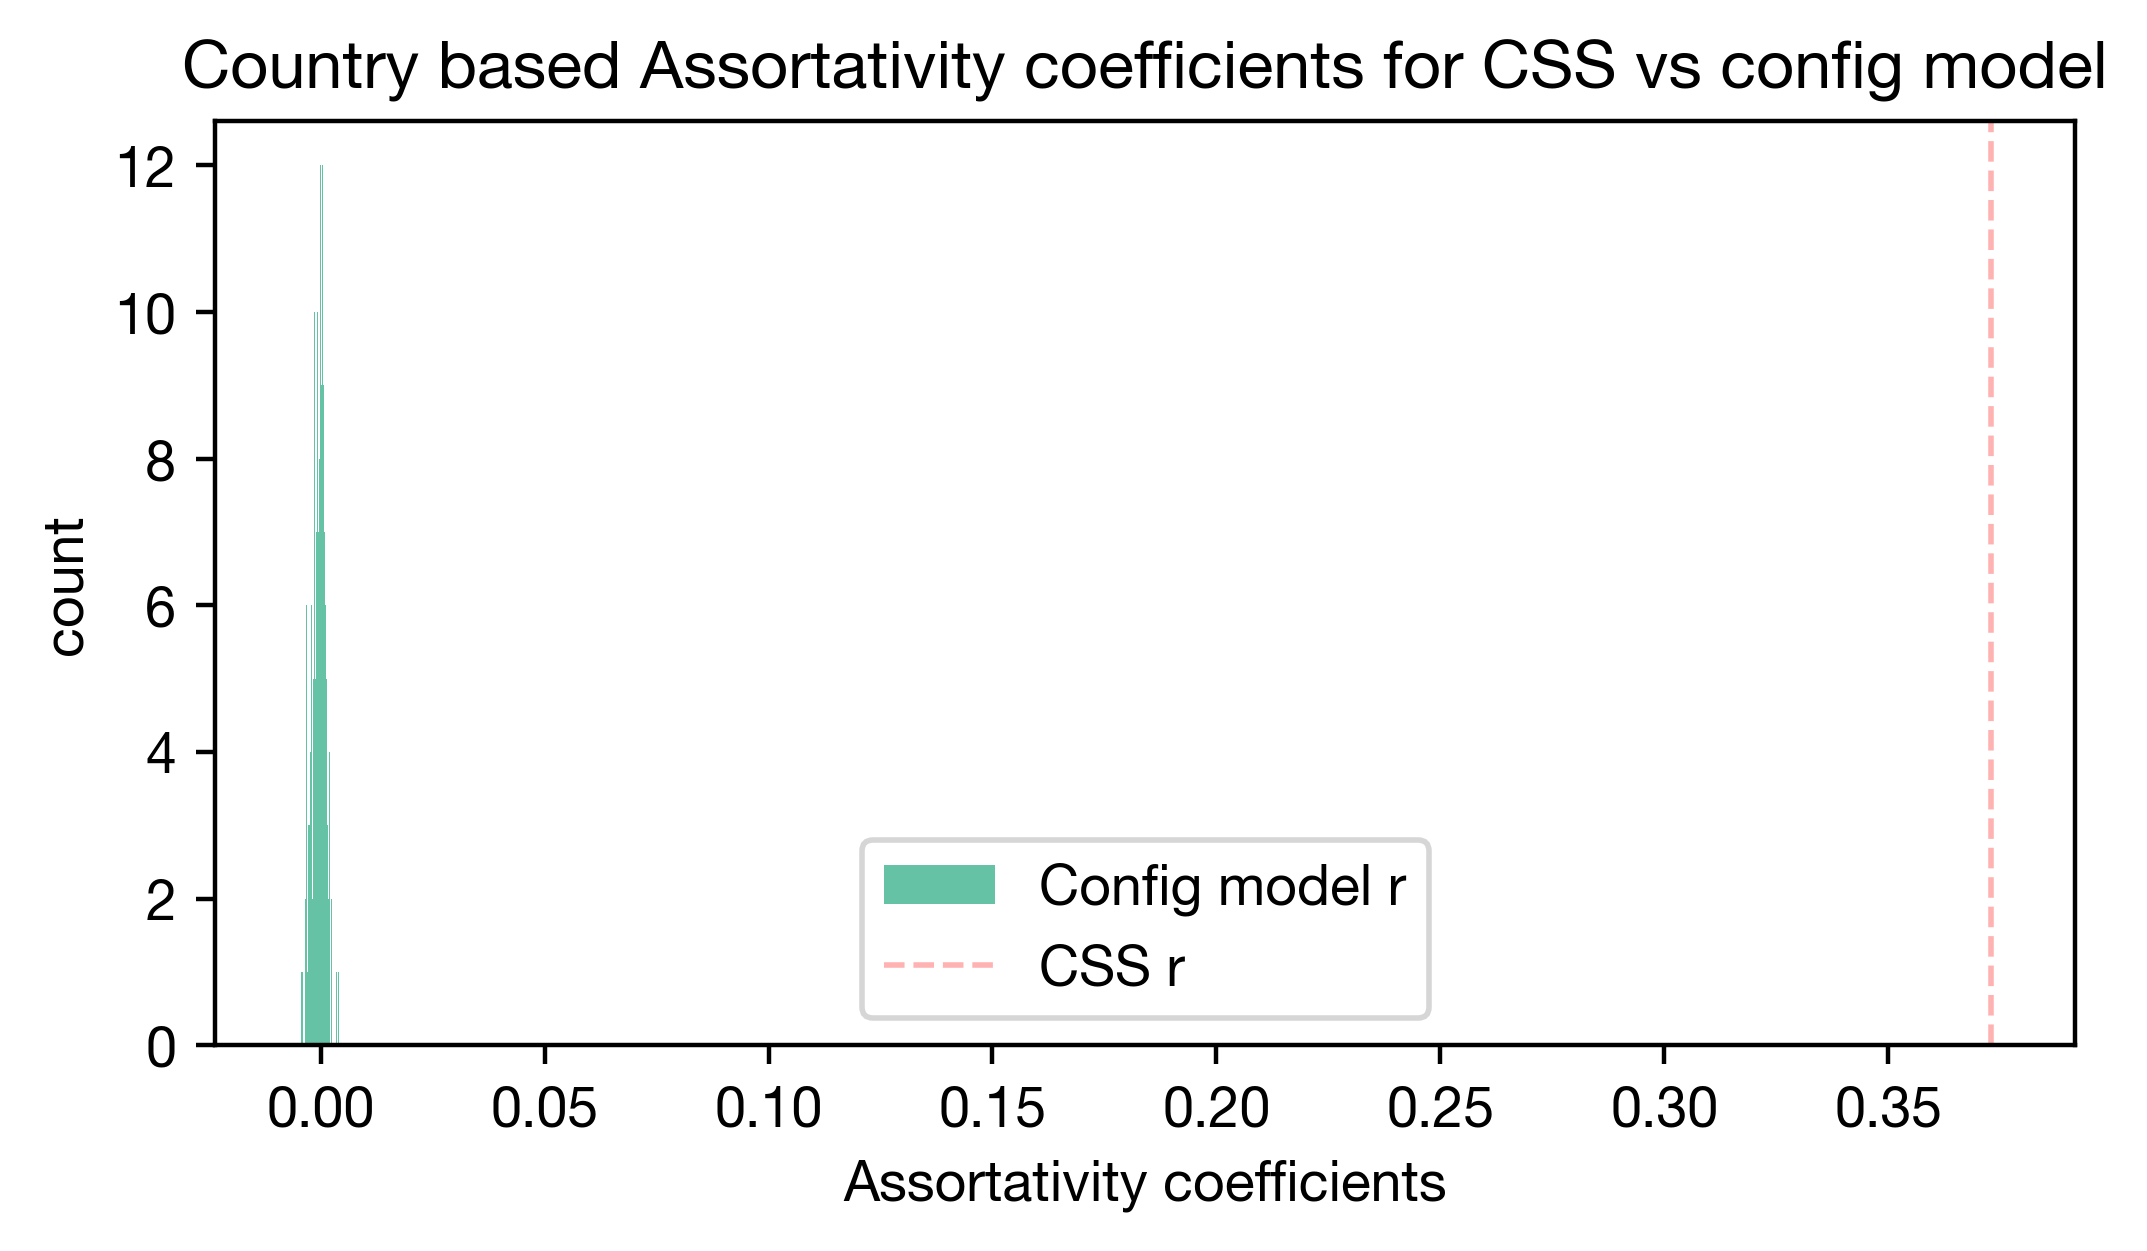

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(assortativity_coefs, bins = 50, label = 'Config model r')
ax.axvline(x = r_CSS, color='red', linestyle='--', label='CSS r', alpha = 0.3)
ax.set_xlabel('Assortativity coefficients')
ax.set_ylabel('count')
ax.set_title('Country based Assortativity coefficients for CSS vs config model')
ax.legend()

plt.show()

As can be seen above there is a significant difference in the assortativity coefficients of the config models and of the CSS network, which indicates that there is significant evidence that based on country the CSS network is assortative

In [ ]:
# Part 4
def get_deg_assortativity_coef(G):
    degrees = dict(G.degree())
    N = len(G.edges())

    same_deg = 0
    for (i, j) in list(G.edges()): # Compute total amount of edges between nodes of equal degree
        if degrees[i] == degrees[j]:
            same_deg += 1/N

    degs = np.array(list(degrees.values()))
    exp_same_deg = 0
    total_half_stubs = sum(degs)
    for deg in set(degs): # Compute expected number of edges between nodes of same degree 
        n_deg = len(degs[degs == deg])
        n_half_stubs = n_deg*deg
        exp_same_deg += (n_half_stubs/total_half_stubs)**2
    # Compute assortativity coefficient
    r = (same_deg - exp_same_deg)/(1-exp_same_deg)
    return r
r_deg_CSS = get_deg_assortativity_coef(S)
r_deg_CSS

0.09033971013493546

In [13]:
assortativity_coefs = []
for i in tqdm(range(200)):
    config_model = get_config_model(S)
    assortativity_coefs.append(get_deg_assortativity_coef(config_model))

100%|██████████| 200/200 [09:35<00:00,  2.88s/it]


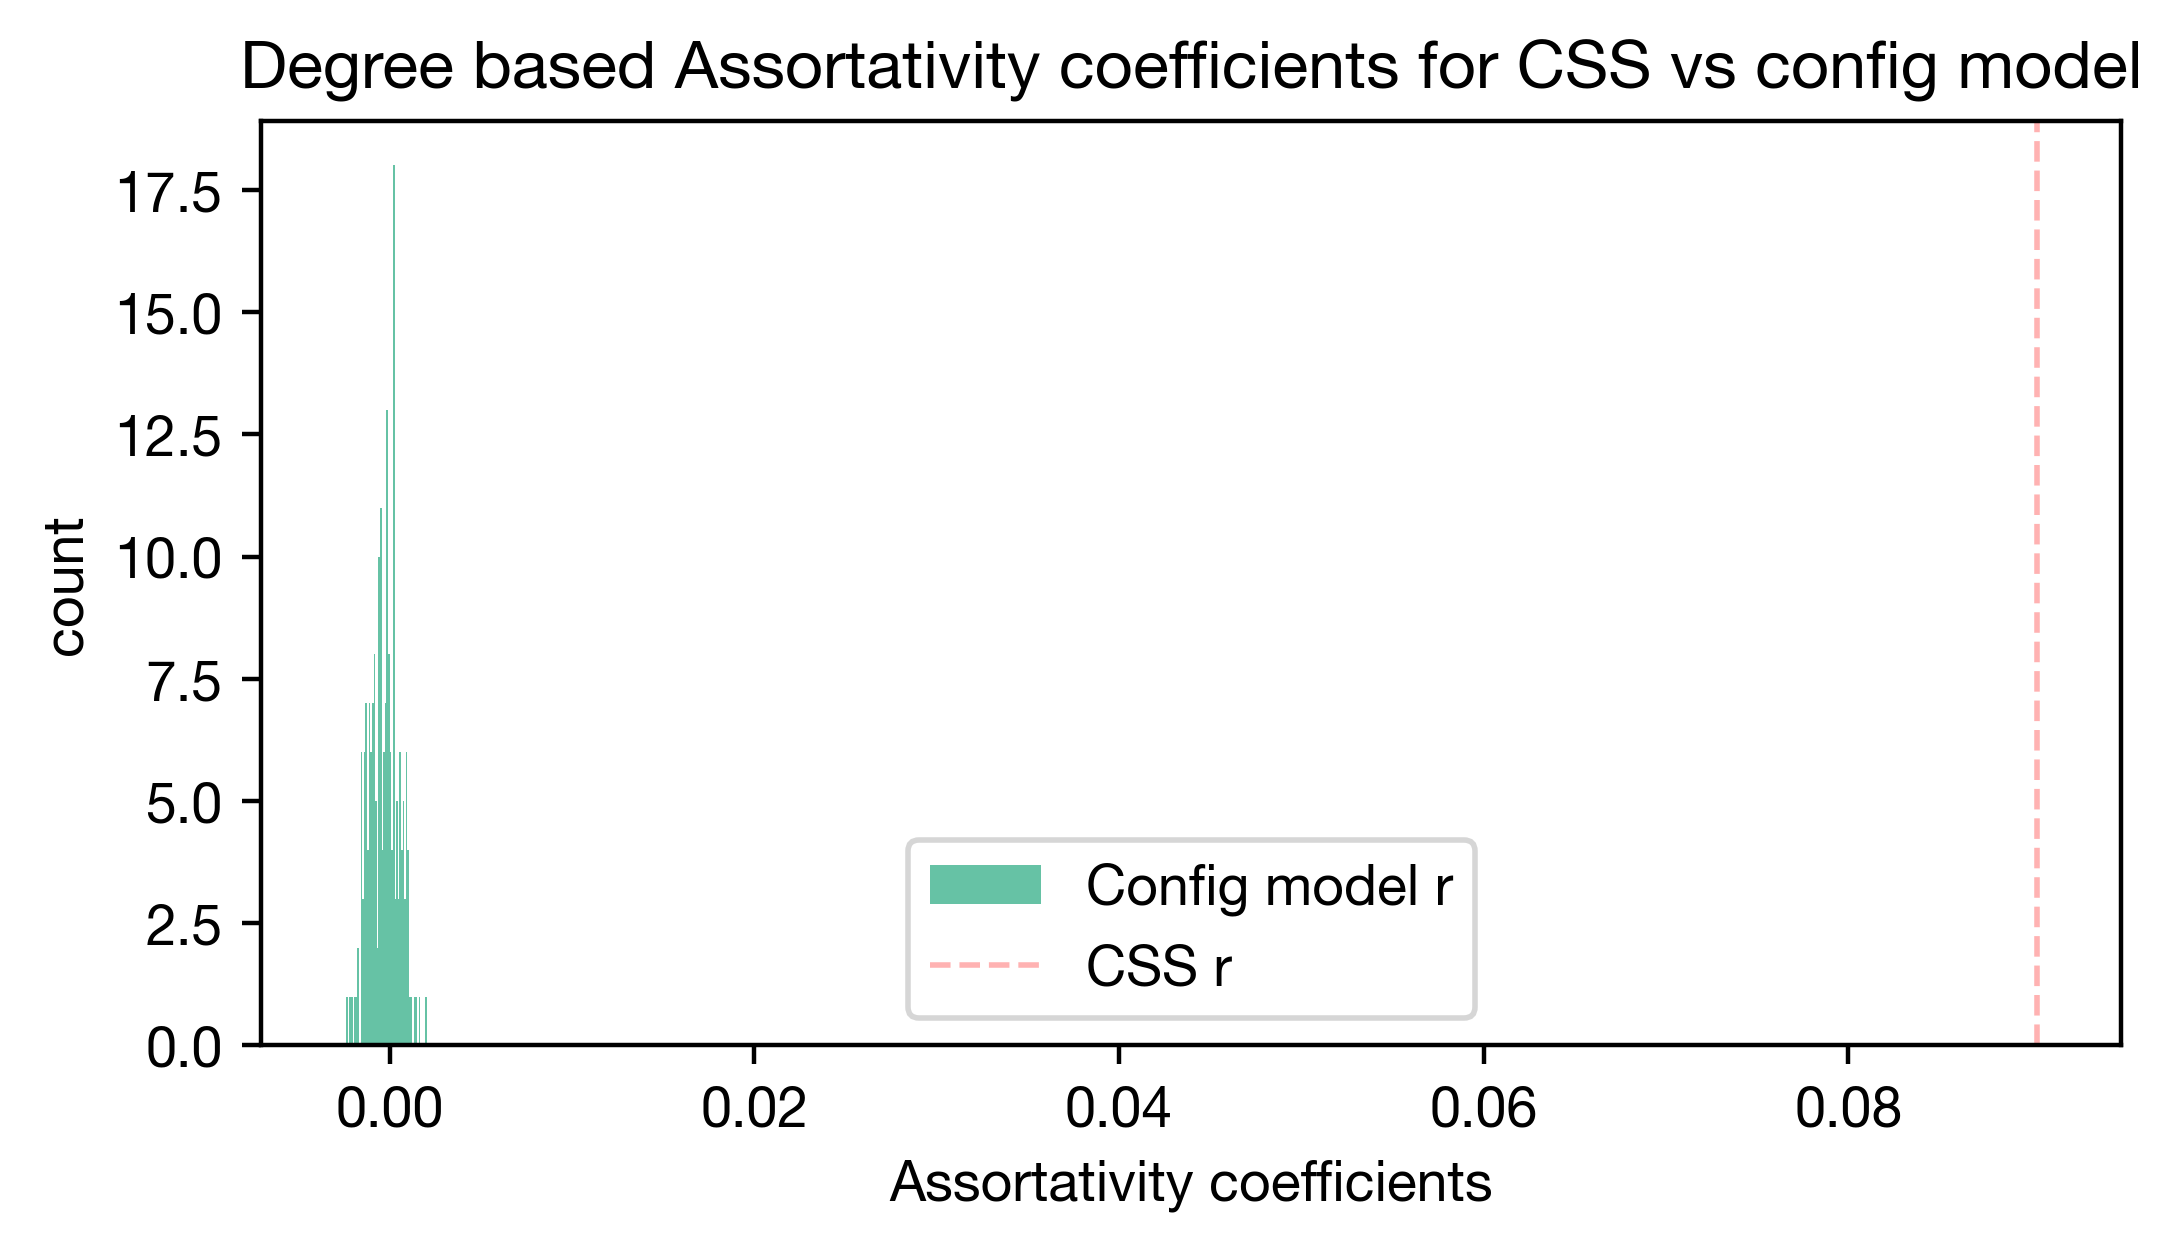

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(assortativity_coefs, bins = 50, label = 'Config model r')
ax.axvline(x = r_deg_CSS, color='red', linestyle='--', label='CSS r', alpha = 0.3)
ax.set_xlabel('Assortativity coefficients')
ax.set_ylabel('count')
ax.set_title('Degree based Assortativity coefficients for CSS vs config model')
ax.legend()

plt.show()

Again we see that the assortativity coefficient of the CSS network is significantly different from the random networks, although smaller than last time. This means that authors are more likely to collaborate with authors of similar degree as them, but this coralation is smaller than based on countries.

> __Part 5: Reflection questions__    
> 7. *Assortativity by degree.* Were the results of the degree assortativity in line with your expectations? Why or why not?

The results align with my expectations that the network is assortative as it is. This can be for the same reasons that hollywood marriages are assortative, in that we are often more attracted to people in similar positions as us. Although the corelation is quite small in this case.

> 8. *Edge flipping.* In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing *e_1* from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?

I think that the reason for flipping 50\% of the edges is to avoid biasing the bottom half of authors to get more edges, as it is the first node who keeps the edge but switches the node it is connected to. Since the network was generated based on sorted pairs to avoid trying to generate the edge twice, the authors with lower index would be get more edges if we didn't flip.

> 9. *Distribution of assortativity in random networks.* Describe the distribution of degree assortativity values you observed for the random networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.  

As expected the random networks are uncorrolated networks. The nature of the configuration model removes the assortative structure by swapping edges at random, which completely removes the assortativeness as the new edge is assigned at random and doesn't care about the degree or any other attributes of the new connected node. 

> **Exercise 2: Central nodes.** Remember to write your answers in the notebook. 
> * Find the 5 most central scientists according to the closeness centrality. What role do you imagine scientists with high closeness centrality play? 
> * Find the 5 most central scientists according to eigenvector centrality.     
> * Plot the closeness centrality of nodes vs their degree. Is there a correlation between the two? Did you expect that? Why?    
> * Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?

In [21]:
# Closeness centrality
closeness = [(id, centrality) for id, centrality in nx.closeness_centrality(S).items()]
closeness_sorted = sorted(closeness, key=lambda x: x[1], reverse=True)
print('5 most central authors based on closeness centrality')
for i in range(5): print(f'{closeness_sorted[i][0]}: Closeness: {round(closeness_sorted[i][1], 2)}, Degree: {S.degree[closeness_sorted[i][0]]}')

5 most central authors based on closeness centrality
https://openalex.org/A5007176508: Closeness: 0.26, Degree: 209
https://openalex.org/A5056499434: Closeness: 0.25, Degree: 112
https://openalex.org/A5048877432: Closeness: 0.25, Degree: 108
https://openalex.org/A5010495671: Closeness: 0.25, Degree: 84
https://openalex.org/A5040448723: Closeness: 0.25, Degree: 42


The authors having high closeness could likely play the role of organising or leading reaserch projects, as this lets them work with many people and qould make them a more central part of the CSS community. These people are also propably more likely to connect with other organisers or leaders which makes the average path to others shorter on average.

In [22]:
# Eigenector centrality
ev_centrality = [(id, centrality) for id, centrality in nx.eigenvector_centrality(S, max_iter=1000000, tol=1e-10).items()]
ev_centrality_sorted = sorted(ev_centrality, key=lambda x: x[1], reverse=True)
print('5 most central authors based on closeness centrality')
for i in range(5): print(f'{ev_centrality_sorted[i][0]}: {round(ev_centrality_sorted[i][1], 2)}, Degree: {S.degree[ev_centrality_sorted[i][0]]}')

5 most central authors based on closeness centrality
https://openalex.org/A5083991449: 0.45, Degree: 220
https://openalex.org/A5031201037: 0.22, Degree: 72
https://openalex.org/A5054114697: 0.21, Degree: 72
https://openalex.org/A5089191285: 0.21, Degree: 59
https://openalex.org/A5049411008: 0.19, Degree: 51


None of the top 5 are the same between closeness and eigenvector centrality

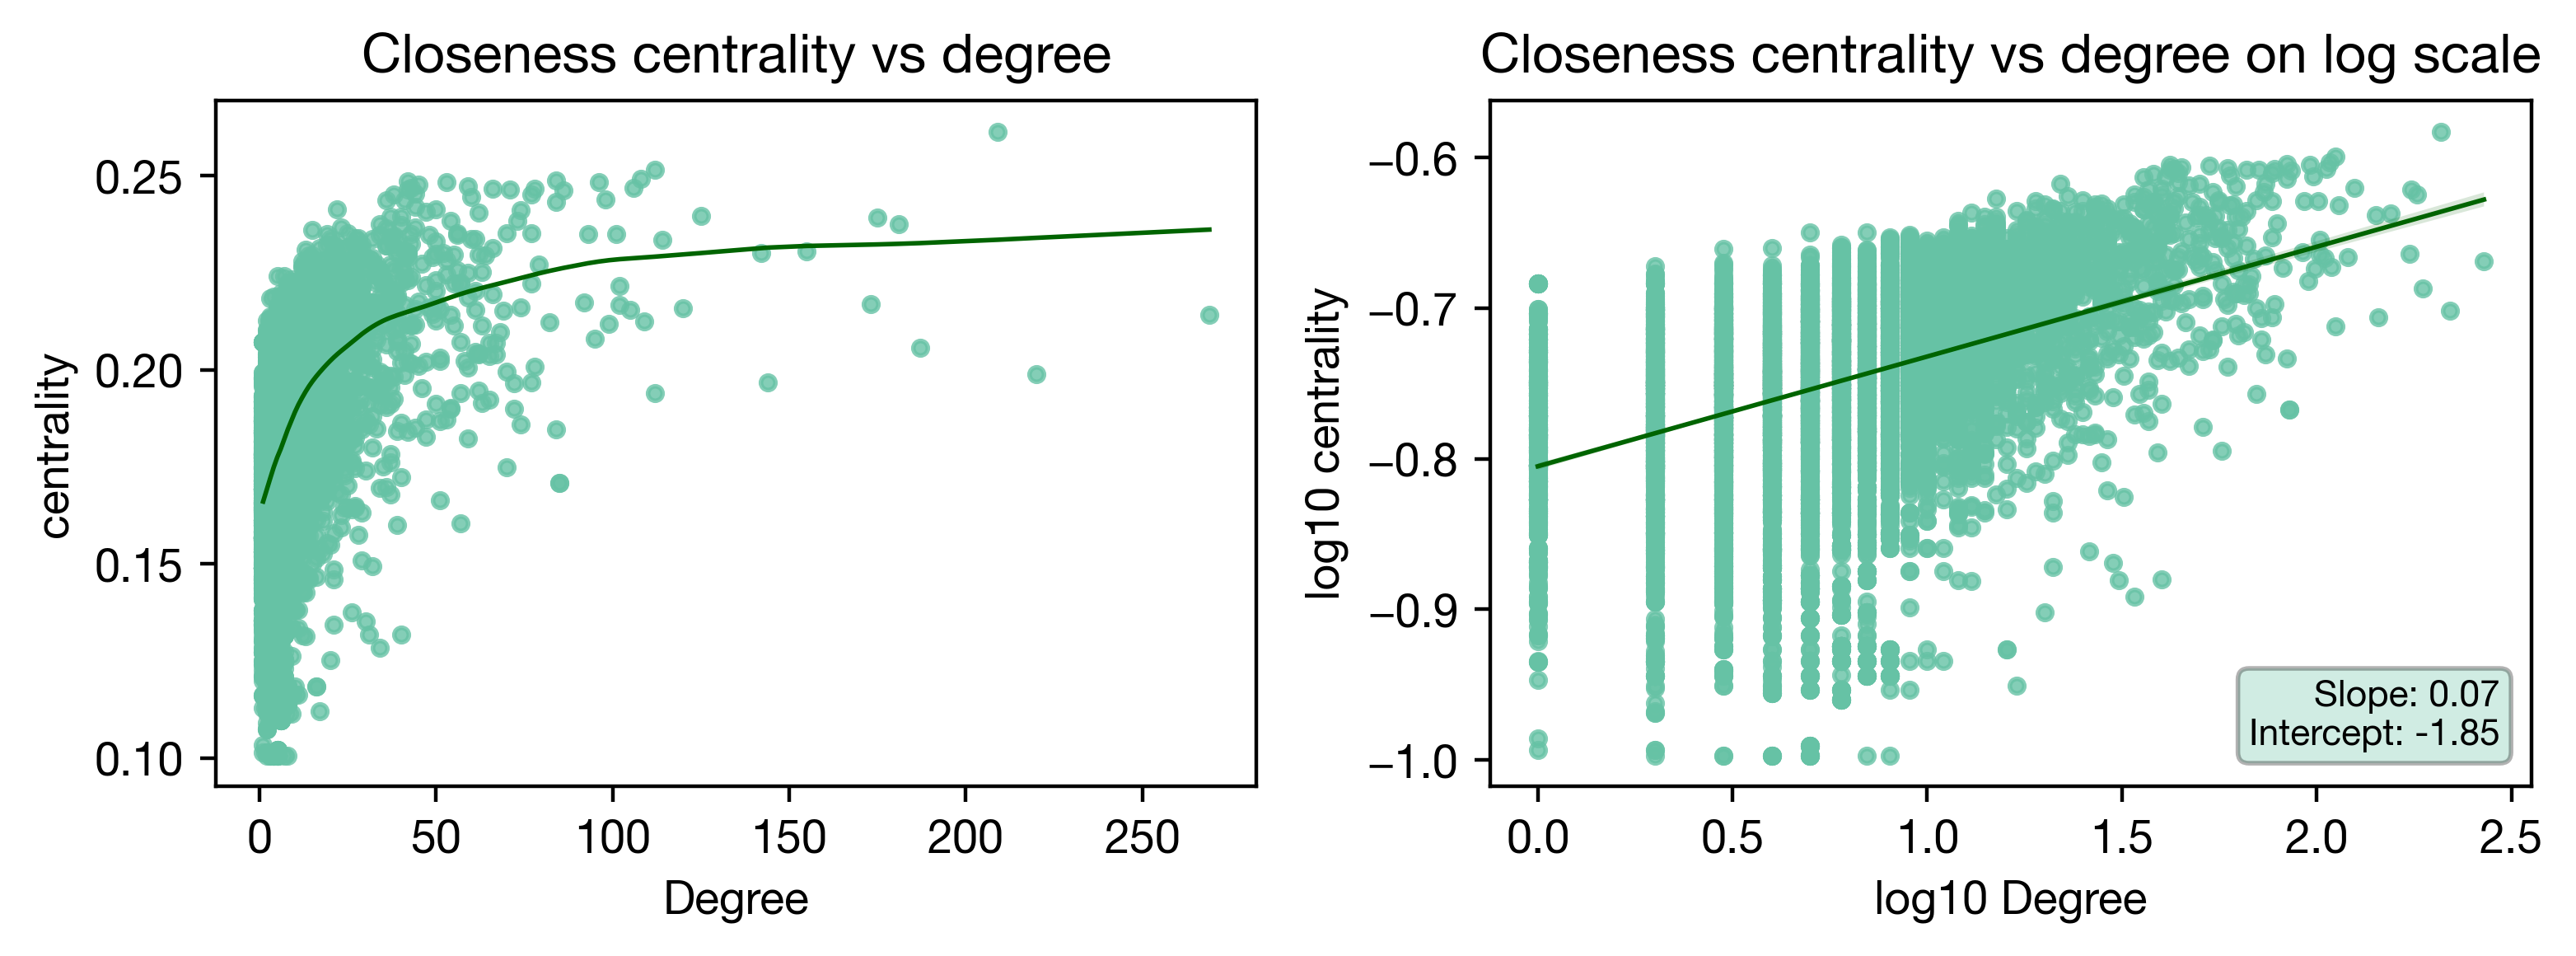

In [32]:
# Closeness centrality over degree plot
import seaborn as sns
import pandas as pd
closeness_degree = []
degrees = S.degree
for id, centrality in closeness:
    closeness_degree.append([degrees[id], centrality])
closeness_degree = np.array(closeness_degree)
x, y = closeness_degree[:,0], closeness_degree[:,1]
slope, intercept = np.polyfit(np.log(x), np.log(y), 1)

fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.regplot(x = x, y = y, scatter_kws={'s':10}, line_kws={'color': 'darkgreen', 'lw': 1}, lowess=True, ax=ax[0])
sns.regplot(x = np.log10(x), y = np.log10(y), scatter_kws={'s':10}, line_kws={'color': 'darkgreen', 'lw': 1}, ax=ax[1])
ax[0].set_title('Closeness centrality vs degree')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('centrality')
ax[1].set_title('Closeness centrality vs degree on log scale')
ax[1].set_xlabel('log10 Degree')
ax[1].set_ylabel('log10 centrality')
plt.tight_layout()
ax[1].text(0.97, 0.05, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}', transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', fontsize=8, bbox=dict(boxstyle="round", alpha=0.3))
plt.show()

When plotted in the log scale we can see that there is a slight correlation between closeness and degree, which one might expect as the higher degree you have the more likely you are to have shorter average shortest paths to other nodes. Having a higher degree also increases the probability that the node is connected to other nodes of high degree, wihch again contributes to the shorter average shortest paths.

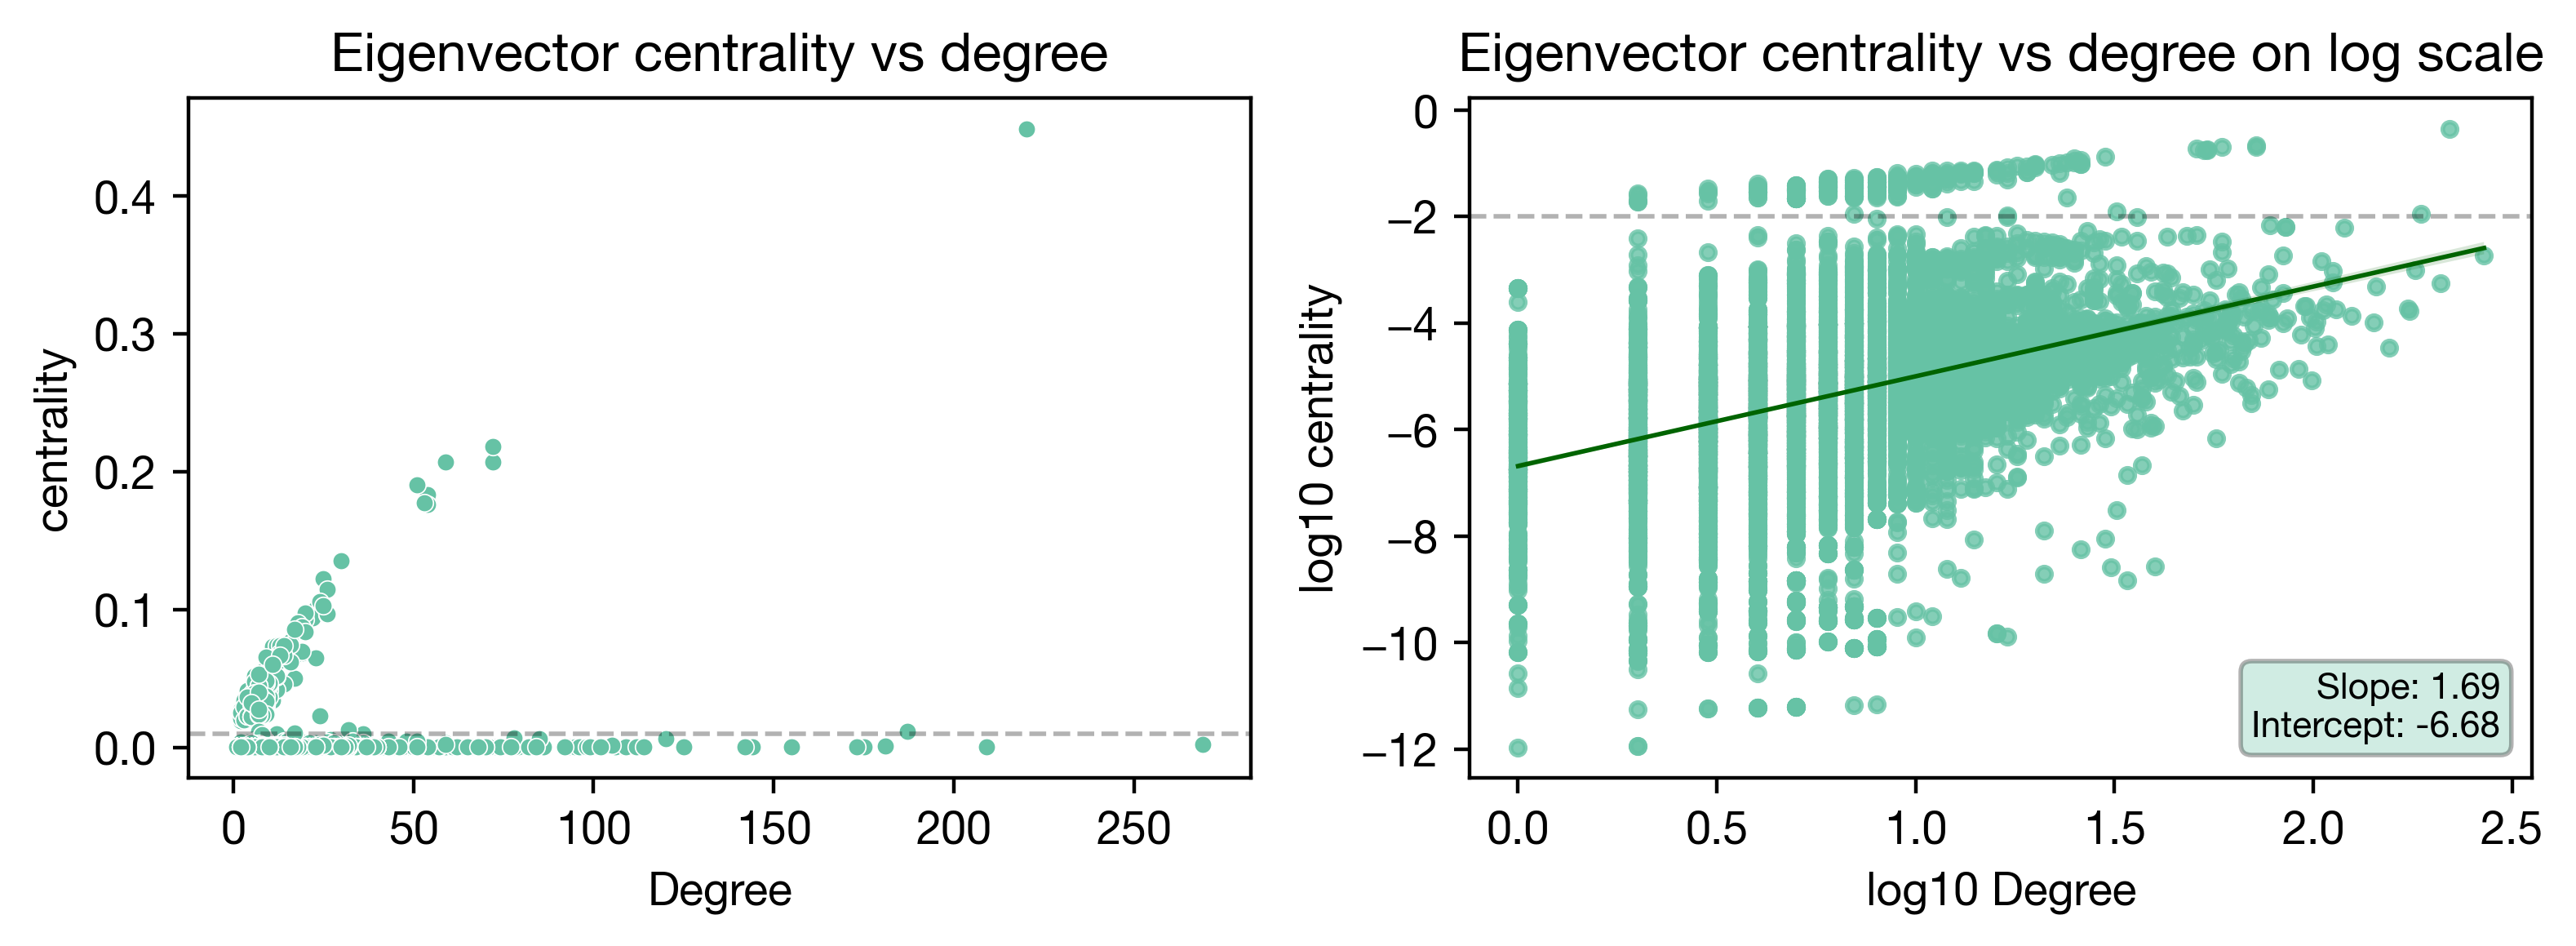

In [33]:
# Eigencevtor centrality over degree
ev_degree = []
degrees = S.degree
for id, centrality in ev_centrality:
    ev_degree.append([degrees[id], centrality])
ev_degree = np.array(ev_degree)
x, y = ev_degree[:,0], ev_degree[:,1]
slope, intercept = np.polyfit(np.log10(x), np.log10(y), 1)

fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.scatterplot(x = x, y = y, s=15, ax=ax[0])
sns.regplot(x = np.log10(x), y = np.log10(y), scatter_kws={'s':10}, line_kws={'color': 'darkgreen', 'lw': 1}, ax=ax[1])
ax[0].axhline(y = 0.01, color='black', linestyle='--', label='CSS r', alpha = 0.3)
ax[1].axhline(y = -2, color='black', linestyle='--', label='CSS r', alpha = 0.3)
ax[0].set_title('Eigenvector centrality vs degree')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('centrality')
ax[1].set_title('Eigenvector centrality vs degree on log scale')
ax[1].set_xlabel('log10 Degree')
ax[1].set_ylabel('log10 centrality')
plt.tight_layout()
ax[1].text(0.97, 0.05, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}', transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', fontsize=8, bbox=dict(boxstyle="round", alpha=0.3))
plt.show()

There seems to be a stronger correlation between eigenvector centrality and degree. This was also as expected as 'important' people often have more connections. Interestingly, there is a group of authors whom can be seen as the almost linearly increasing dots in the left plot, and above -2 in the log scale plot, which are much more 'important' than everyone else. I would expect that these authors collaborate mostly with each other and thefore reinforce their centrality value. This is proved below where the assortativity coefficient when splitting the network into these two groups of high and low importance is very high (0.88). Showing that there is a circle of what is considered important authors by the algorithm.

In [25]:
# Compute assortativity of eigenvector centrality
degrees = dict(S.degree())
E = len(S.edges())
    
threshold = 0.01
thresholded_ev_ids = set(id for id, t in ev_centrality if t > threshold)

same_ev = 0
for (i, j) in list(S.edges()): # Compute total amount of edges between nodes of same country
    if i in thresholded_ev_ids and j in thresholded_ev_ids:
        same_ev += 1/E
    elif i not in thresholded_ev_ids and j not in thresholded_ev_ids:
        same_ev += 1/E
            
degs = np.array(list(degrees.values()))
total_half_stubs = sum(degs)
ev_deg_sum = {}
for node in S.nodes():
    if node in thresholded_ev_ids:
        ev_deg_sum['high_ev'] = ev_deg_sum.get('high_ev', 0) + degrees[node]
    else: 
        ev_deg_sum['low_ev'] = ev_deg_sum.get('low_ev', 0) + degrees[node]
    
exp_same_ev = sum((country_half_stubs/total_half_stubs)**2 for country_half_stubs in ev_deg_sum.values()) 
r = (same_ev - exp_same_ev)/(1-exp_same_ev)
print(f'Assortativity coefficient of network based on high and low eigenvector centrality (threshold: 0.01 centrality): {r}')

Assortativity coefficient of network based on high and low eigenvector centrality (threshold: 0.01 centrality): 0.8767963764926879


## Part 3 - Words that characterize Computational Social Science communities

These exercises are taken from Week 8
> __Exercise 1: TF-IDF and the Computational Social Science communities.__ The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists.
> What you need for this exercise: 
>    * The assignment of each author to their network community, and the degree of each author (Week 6, Exercise 4). This can be stored in a dataframe or in two dictionaries, as you prefer.  
>    * the tokenized _abstract_ dataframe (Week 7, Exercise 2)
>
> 1. First, check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 
>   * What does TF stand for? 
>   * What does IDF stand for?


In [21]:
import json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import seaborn as sns
import random
from joblib import delayed, Parallel
from collections import defaultdict
from community import community_louvain
#from wordcloud import WordCloud
import ast
from functools import lru_cache
from collections import Counter
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
from nltk import PorterStemmer, bigrams as nltk_bigrams
from heapq import nlargest
import nltk
import re
from nltk.corpus import stopwords
from PIL import Image

sns.set_theme(style="darkgrid")
seed = 42
np.random.seed(seed)
random.seed(seed)

In [12]:
def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    G = nx.readwrite.json_graph.node_link_graph(data)
    return G

In [15]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [41]:
graph_file = "network.json"
G = load_graph(graph_file)
G_louvain_partitions = louvain_partitions(G)
author_degrees = dict(G.degree())
author_data = pd.DataFrame({
    "author": list(author_degrees.keys()),
    "degree": list(author_degrees.values()),
    "community": [next((i for i, com in enumerate(G_louvain_partitions) if author in com)) for author in author_degrees.keys()]
})

papers_df = pd.read_csv("C:/DTU/Computational Social Science/CSS_group13/final_papers.csv")
papers_df['id'] = papers_df['id'].map(lambda x: x[21:])
papers_df['author_ids'] = papers_df['author_ids'].apply(ast.literal_eval)
papers_df['author_ids'] = papers_df['author_ids'].apply(lambda x: [y[21:] for y in x])

abstracts_df = pd.read_csv("C:/DTU/Computational Social Science/CSS_group13/final_abstracts.csv")
abstracts_df['id'] = abstracts_df['id'].map(lambda x: x[21:])
abstracts_df["abstract_inverted_index"] = abstracts_df["abstract_inverted_index"].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else {}
)
abstracts_df["author_ids"] = abstracts_df["id"].map(papers_df.set_index("id")["author_ids"])

def invert_to_text(inverted_index):
    if not inverted_index:
        return ''
    lenght = max(i for p in inverted_index.values() for i in p) + 1
    text = [''] * lenght
    for word, positions in inverted_index.items():
        for i in positions:
            text[i] = word
    return " ".join(text)

abstracts_df["text"] = abstracts_df["abstract_inverted_index"].apply(invert_to_text)
abstracts_df = abstracts_df[abstracts_df["text"].apply(lambda x: len(x) > 0)]

stemmer = PorterStemmer()
pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=10000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [cached_stem(t) for t in tokens] if stem else tokens

abstracts_df["tokens"] = abstracts_df["text"].apply(tokenize)
abstracts_df["bigrams"] = abstracts_df["tokens"].apply(lambda x: list(nltk_bigrams(x)))

bigrams = abstracts_df["bigrams"].dropna().explode().tolist()
abstracts_df = abstracts_df.drop('bigrams', axis=1)
bigrams = [bg for bg in bigrams if not isinstance(bg, float)]

bigram_counter = Counter(bigrams)
first_counter = Counter((bg[0] for bg in bigrams))
second_counter = Counter((bg[1] for bg in bigrams))
N = len(bigrams)

def chi_squared(bg):
    w1, w2 = bg
    nii = bigram_counter[bg]
    nio = first_counter[w1] - nii
    noi = second_counter[w2] - nii
    noo = N - (nii + nio + noi)
    
    R1 = first_counter[w1]
    C1 = second_counter[w2]
    R2 = noi + noo
    C2 = nio + noo
    
    E_ii = R1 * C1 / N
    E_io = R1 * C2 / N
    E_oi = R2 * C1 / N
    E_oo = R2 * C2 / N
    
    X_ii = (nii - E_ii)**2 / E_ii
    X_io = (nio - E_io)**2 / E_io
    X_oi = (noi - E_oi)**2 / E_oi
    X_oo = (noo - E_oo)**2 / E_oo
    
    return X_ii + X_io + X_oi + X_oo

chi2vals = {bg: chi_squared(bg) for bg in bigram_counter}
pvals = {bg: chi2.sf(val, 1) for bg, val in chi2vals.items()}
collocs = {bg: cnt for bg, cnt in bigram_counter.items() if cnt > 50 and pvals[bg] < 0.001}
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
abstracts_df["tokens"] = abstracts_df["tokens"].apply(tokenizer.tokenize)
abstracts_df.to_csv("abstracts_with_tokens.csv", index=False)
final_abstracts_df = pd.read_csv("abstracts_with_tokens.csv")
final_abstracts_df['author_ids'] = final_abstracts_df['author_ids'].apply(ast.literal_eval)
final_abstracts_df['tokens'] = final_abstracts_df['tokens'].apply(ast.literal_eval)

__1.1__
TF stands for term frequency, this measures how often a specific term appears in a set of text document. Here a higher frequency means a higher relevance of the word to the text's content.

__1.3__
IDF stands for inverse document frequency, assigning low values to common words and high weights to less frequent words. Here a lower frequency means a higher relevance of the word to the text's content.


> 2. Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 
>   * Consider a community _c_
>   * Find all the abstracts of papers written by a member of community _c_.
>   * Create a long array that stores all the abstract tokens 
>   * Repeat for all the communities. 
> __Note:__ Here, to ensure your code is efficient, you shall exploit ``pandas`` builtin functions, such as [``groupby.apply``](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) or [``explode``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html).


In [42]:
author_counts = author_data["community"].value_counts().reset_index()
author_counts.columns = ["community", "num_authors"]
comm_docs = final_abstracts_df.explode("author_ids")
comm_docs = comm_docs.merge(author_data, left_on="author_ids", right_on="author")
comm_docs = comm_docs.drop_duplicates(subset=["id", "community"])
comm_docs = comm_docs.groupby("community")["tokens"].sum().reset_index()
comm_docs = comm_docs.merge(author_counts, on="community")

In [43]:
comm_docs.head()

,community,tokens,num_authors
0,0,"[amount, mental, effort, invest, task, influen...",395
1,1,"[eu, countri, hungari, implement, sever, lockd...",334
2,2,"[strength, longrang, tie, seem, reason, would,...",221
3,3,"[strength, longrang, tie, seem, reason, would,...",506
4,4,"[abstract, one, wide_use, approach, quantifi, ...",476


> 3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 
>   * Describe similarities and differences between the communities.
>   * Why aren't the TFs not necessarily a good description of the communities?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?

In [44]:
top5 = comm_docs.sort_values("num_authors", ascending=False).head(5)
top5

,community,tokens,num_authors
10,10,"[conflict, fuel, popular, religi, mobil, rekin...",1264
9,9,"[text_gener, larg_languag, model, prolifer, be...",945
13,13,"[world, digit, inform, ecosystem, continu, str...",630
6,6,"[abstract, one, wide_use, approach, quantifi, ...",565
25,25,"[coalit, format, desir, behavior, multiag_syst...",526


In [45]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

tf = {}

for _, row in top5.iterrows():
    tf[row["community"]] = calculate_tf(row["tokens"])

top5_per_community = {
  comm: nlargest(5, tf_dict.items(), key=lambda x: x[1])
  for comm, tf_dict in tf.items()
}

for community, terms in top5_per_community.items():
    print(f"{community}:")
    for term, score in terms:
        print(f"  {term}: {score}")

10:
  use: 0.0073998147798487665
  user: 0.005316837350932245
  design: 0.004996148739573874
  commun: 0.004822317529678682
  system: 0.0036714350365794814
9:
  model: 0.008059100067159167
  use: 0.006707968892191654
  task: 0.00575422923927341
  gener: 0.0046057677405510235
  system: 0.004200428388060769
13:
  network: 0.006641291211583858
  model: 0.005455346352372455
  use: 0.004873668635711623
  user: 0.004540474603837943
  system: 0.0040604493036809465
6:
  polit: 0.007270608274687346
  use: 0.005325205074185307
  effect: 0.0053072750907705414
  find: 0.00446456587027657
  studi: 0.003666681608319512
25:
  model: 0.0067446128232779
  use: 0.005297311614355715
  user: 0.005250014189227538
  data: 0.0050608244887148345
  network: 0.0048054183930226835


In [56]:
def calculate_IDF(docs):
    N = len(docs)
    tokens = docs[["community", "tokens"]].explode("tokens").drop_duplicates()
    df_counts = tokens['tokens'].value_counts()
    IDF = np.log(N / df_counts)

    return IDF.sort_values(ascending=False).to_dict()

In [55]:
calculate_IDF(comm_docs)

{'parkingspac': 5.043425116919247,
 'alattentiondeficithyperact': 5.043425116919247,
 'prelearn': 5.043425116919247,
 'responsetotarget': 5.043425116919247,
 'lobjectif': 5.043425116919247,
 'nonresponsetonontarget': 5.043425116919247,
 'approch': 5.043425116919247,
 'losier': 5.043425116919247,
 'alerror': 5.043425116919247,
 'reviewj': 5.043425116919247,
 'levelmathemat': 5.043425116919247,
 'thorndik': 5.043425116919247,
 'tannock': 5.043425116919247,
 'detudi': 5.043425116919247,
 'nonstimul': 5.043425116919247,
 'alrol': 5.043425116919247,
 'prepare': 5.043425116919247,
 'approachacta': 5.043425116919247,
 'disordernat': 5.043425116919247,
 'investigationbox': 5.043425116919247,
 'adequat': 5.043425116919247,
 'backpsychiatr': 5.043425116919247,
 'disorderjama': 5.043425116919247,
 'economiqu': 5.043425116919247,
 'adhdus': 5.043425116919247,
 'psychiatrytrend': 5.043425116919247,
 'altam': 5.043425116919247,
 'shrewd': 5.043425116919247,
 'primair': 5.043425116919247,
 'lindustri

> 4. We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors). Then for each community: 
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)
>   * Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?


In [49]:
import math

In [54]:
def analyze_communities(comm_docs, author_data, top_n=9):
    top_comms = comm_docs.sort_values('num_authors', ascending=False).head(top_n)
    idf = calculate_IDF(comm_docs)
    
    return {
        row['community']: {
            'top_tf': [w for w,_ in sorted(calculate_tf(row['tokens']).items(), key=lambda x: -x[1])[:10]],
            'top_tfidf': [w for w,_ in sorted({w:tf*idf.get(w,0) for w,tf in calculate_tf(row['tokens']).items()}.items(), key=lambda x: -x[1])[:10]],
            'top_authors': author_data[author_data['community'] == row['community']].sort_values('degree', ascending=False).head(3)['author'].tolist()
        }
        for _, row in top_comms.iterrows()
    }

for comm, data in analyze_communities(comm_docs, author_data).items():
    print(f"Community {comm}:\n  Top TF: {', '.join(data['top_tf'])}\n  Top TF-IDF: {', '.join(data['top_tfidf'])}\n  Top 3 Authors: {', '.join(data['top_authors'])}\n")

Community 10:
  Top TF: use, user, design, commun, system, peopl, task, data, particip, inform
  Top TF-IDF: user, commun, design, peopl, task, particip, onlin, interact, social_media, technolog
  Top 3 Authors: A5043228682, A5076189854, A5045528962

Community 9:
  Top TF: model, use, task, gener, system, data, approach, method, perform, learn
  Top TF-IDF: task, model, text, dataset, word, user, semant, annot, train, learn
  Top 3 Authors: A5087088138, A5091272738, A5068508539

Community 13:
  Top TF: network, model, use, user, system, differ, dynam, data, studi, inform
  Top TF-IDF: network, user, dynam, twitter, model, commun, social_media, individu, system, social
  Top 3 Authors: A5021346979, A5081008532, A5011228873

Community 6:
  Top TF: polit, use, effect, find, studi, inform, research, polici, measur, data
  Top TF-IDF: polit, elect, voter, partisan, belief, vote, parti, social_media, polici, news
  Top 3 Authors: A5013670125, A5056499434, A5020533147

Community 25:
  Top TF:


 __Exercise 2: The Wordcloud__. It's time to visualize our results!

> * Install the [`WordCloud`](https://pypi.org/project/wordcloud/) module. 
> * Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
> * Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration). 
> * Comment on your results. What can you conclude on the different sub-communities in Computational Social Science? 
> * Look up online the top author in each community. In light of your search, do your results make sense?

 __Exercise 3: Computational Social Science__ 

> * Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science. 
> * In light of your data-driven analysis, has your understanding of the field changed? How? __(max 150 words)__